C:\Users\hruia\PycharmProjects\VarPhenClustering\src\data_processing\data_loading_utils.py:453: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  cond1 = X[self.id_col].is_monotonic



MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6642/6642 [00:12<00:00, 525.35it/s]
C:\Users\hruia\PycharmProjects\VarPhenClustering\src\visualisation\visualisation_utils.py:351: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  feat_dist = group_data.groupby(id_col).apply(lambda x: x[feat].iloc[0]).values
C:\Users\hruia\PycharmProjects\VarPhenClustering\src\visualisation\visualisation_utils.py:360: RuntimeWarning: Mean of empty slice
  mean, std = np.nanmean(feat_dist), np.nanstd(feat_dist)
C:\User


MIMIC data successfully loaded.

Basic information 
 Input shape: (6642, 10, 9), (6642, 4) 
 Outcome Distribution: De      33
I     1126
W     4684
Di     799
dtype: int64


C:\Users\hruia\PycharmProjects\VarPhenClustering\src\visualisation\visualisation_utils.py:477: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  nanmean = data.groupby(time_col).apply(lambda x: np.nanmean(x[feat]))
C:\Users\hruia\PycharmProjects\VarPhenClustering\src\visualisation\visualisation_utils.py:499: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence th

C:\Users\hruia\PycharmProjects\VarPhenClustering\src\visualisation\visualisation_utils.py:477: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  nanmean = data.groupby(time_col).apply(lambda x: np.nanmean(x[feat]))
C:\Users\hruia\PycharmProjects\VarPhenClustering\src\visualisation\visualisation_utils.py:499: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence th

                 De              I              W             Di
0               0.0  4.940656e-324  9.881313e-324  1.482197e-323
ESI mean        NaN            NaN            NaN            NaN
ESI IQR         NaN            NaN            NaN            NaN
ESI min-max     NaN            NaN            NaN            NaN
age mean        NaN            NaN            NaN            NaN
age IQR         NaN            NaN            NaN            NaN
age min-max     NaN            NaN            NaN            NaN
gender mean     NaN            NaN            NaN            NaN
gender IQR      NaN            NaN            NaN            NaN
gender min-max  NaN            NaN            NaN            NaN







KeyError: 'model_name'

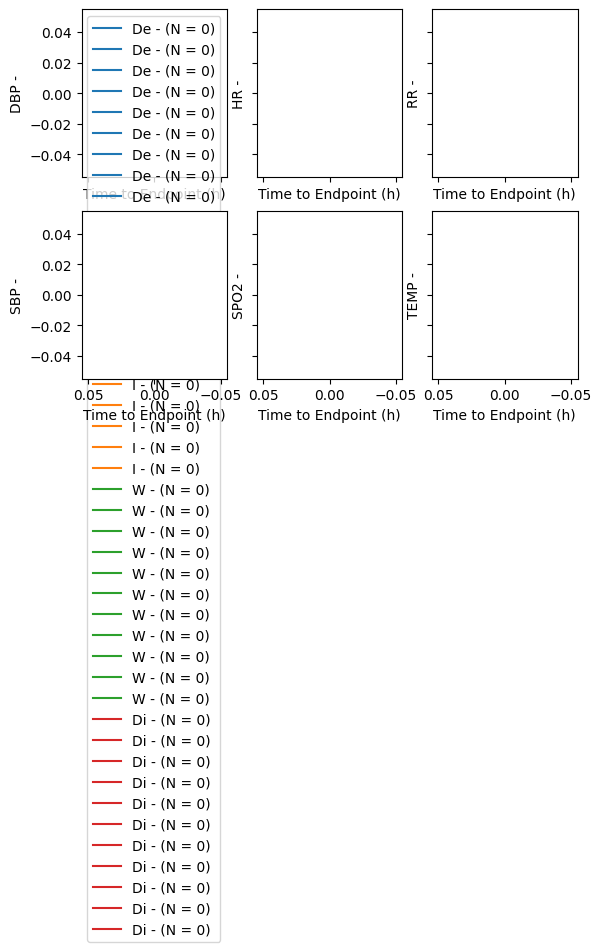

In [1]:

import json
import matplotlib.pyplot as plt

from src.data_processing.data_loader import data_loader
import src.models.model_utils as model_utils
from src.results.main import evaluate
import src.visualisation.main as vis_main


# ---------------------------- Load Configurations --------------------------------------
with open("src/training/data_config.json", "r") as f:
    data_config = json.load(f)
    f.close()

with open("src/training/model_config.json", "r") as f:
    model_config = json.load(f)
    f.close()

with open("src/training/training_config.json", "r") as f:
    training_config = json.load(f)
    f.close()

# ----------------------------- Load Data and Plot summary statistics -------------------------------

"Data Loading."
data_info = data_loader(**data_config)

"Visualise Data Properties"
vis_main.visualise_data_groups(data_info)

# -------------------------- Loading and Training Model -----------------------------

"Load model and fit"
print("\n\n\n\n")
model = model_utils.get_model_from_str(data_info=data_info, model_config=model_config,
                                       training_config=training_config)

# Train model
history = model.train(data_info=data_info, **training_config)


In [ ]:
from sklearn

In [2]:
data_config

{'data_name': 'MIMIC',
 'target_window': 24,
 'feat_set': 'vit-sta',
 'time_range': [0, 10],
 'train_test_ratio': 0.6,
 'train_val_ratio': 0.4,
 'seed': 2323}

In [3]:
data_info = data_loader(**data_config)

C:\Users\hruia\PycharmProjects\VarPhenClustering\src\data_processing\data_loading_utils.py:453: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  cond1 = X[self.id_col].is_monotonic



MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6642/6642 [00:13<00:00, 505.38it/s]



MIMIC data successfully loaded.

Basic information 
 Input shape: (6642, 10, 9), (6642, 4) 
 Outcome Distribution: De      33
I     1126
W     4684
Di     799
dtype: int64
